# Probabilistic Principal Component Analysis

Probabilistic principal components analysis (PCA) is a dimensionality reduction technique that analyzes data via a lower dimensional latent space (Tipping & Bishop, 1999). It is often used when there are missing values in the data or for multidimensional scaling.

This tutorial is a revision of the [Edward tutorial for Probabilistic PCA](http://edwardlib.org/tutorials/probabilistic-pca) using TensorFlow Probability stack, with an additional example of inference by Hamiltonian Monte Carlo.

In [1]:
import IPython
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import seaborn as sns; sns.set_context('notebook')
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed

## Data
We use simulated data. We'll talk about the individual variables and what they stand for in the next section. For this example, each data point is 2-dimensional, $\mathbf{x}_{n}\in\mathbb{R}^{2}$.

In [2]:
def build_toy_dataset(N, D, K, sigma=1.0):
    x_train = np.zeros((D, N))
    w = np.random.normal(0.0, 2.0, size=(D, K))
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    for d in range(D):
        for n in range(N):
            x_train[d, n] = np.random.normal(mean[d, n], sigma)
    print("True principal axes:")
    print(w)
    return x_train

In [3]:
N = 1000  # number of data points
D = 2     # data dimensionality
K = 1     # latent dimensionality

x_train = build_toy_dataset(N, D, K)

True principal axes:
[[-1.82415729]
 [ 1.32370415]]


We visualize the data.

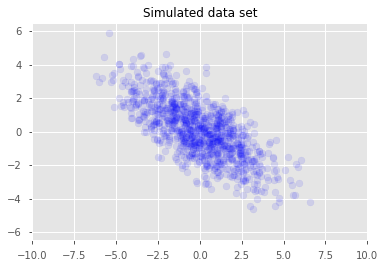

In [4]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis('equal')
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

## Model

Consider a data set $\mathbf{X}=\{\mathbf{x}_{n}\}$ of $N$ data points, where each data point is $D$-dimensional, $\mathbf{x}_{n}\in\mathbb{R}^{D}$. We aim to represent each $\mathbf{x}_{n}$ under a latent variable $\mathbf{z}_{n}\in\mathbb{R}^{K}$ with lower dimension, $K<D$. The set of principal axes $\mathbf{W}$ relates the latent variables to the data.

Specifically, we assume that each latent variable is normally distributed,
$$\mathbf{z}_{n}\sim N(\mathbf{0}, \mathbf{I}).$$

The corresponding data point is generated via a projection,
$$\mathbf{x}_{n}\mid\mathbf{z}_{n}\sim N(\mathbf{W}\mathbf{z}_{},\sigma^{2}\mathbf{I}),$$

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as the principal axes. In probabilistic PCA, we are typically interested in estimating the principal axes $\mathbf{W}$ and the noise term $\sigma^{2}$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the latent variable, the distribution of each data point is

$$\mathbf{x}_{n}\sim N(\mathbf{0},\mathbf{W}\mathbf{W}^{T}+\sigma^{2}\mathbf{I}).$$

Classical PCA is the specific case of probabilistic PCA when the covariance of the noise becomes infinitesimally small, $\sigma^{2}\to 0.$
We set up our model below. In our analysis, we fix $\sigma=2.0$, and instead of point estimating $\mathbf{W}$ as a model parameter, we place a prior over it in order to infer a distribution over principal axes.

In [5]:
def ppca_model():
    """Define Probabilistic PCA model."""
    sigma = tf.constant(2.0, name='sigma')
    w = ed.Normal(loc=tf.zeros([D, K]),
                  scale=sigma*tf.ones([D, K]),
                  name='w')
    z = ed.Normal(loc=tf.zeros([N, K]),
                  scale=tf.ones([N, K]),
                  name='z')
    x = ed.Normal(loc=tf.matmul(w, z, transpose_b=True),
                  scale=tf.ones([D, N]),
                  name='x')
    return x

We visualize the model with TensorBoard.

In [6]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def draw_graph(model, *args, **kwargs):
    """Visualize TensorFlow graph."""
    graph = tf.Graph()
    with graph.as_default():
        model(*args, **kwargs)
    graph_def = graph.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=32)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    IPython.display.display(IPython.display.HTML(iframe))

In [7]:
draw_graph(ppca_model)

## Inference

The posterior distribution over the principal axes $\mathbf{W}$ cannot be analytically determined. Below, we set up our inference variables and then run a chosen algorithm to infer $\mathbf{W}$.

### Hamiltonian Monte Carlo

Given data, we perform Hamiltonian Monte Carlo (HMC) to calculate the posterior distribution over the model's parameters.

In [ ]:
num_results = 5000
num_burnin_steps = 3000
step_size = 0.02
num_leapfrog_steps = 3
log_joint = ed.make_log_joint_fn(ppca_model)
target_log_prob_fn = lambda w, z: log_joint(w=w, z=z, x=x_train)

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[tf.zeros([D, K], name='init_w'),
                   tf.zeros([N, K], name='init_z')],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=step_size,
        num_leapfrog_steps=num_leapfrog_steps))

w, z = states

with tf.Session() as sess:
    w_, z_, is_accepted_ = \
        sess.run([w, z, kernel_results.is_accepted])

num_accepted = np.sum(is_accepted_)
print('Acceptance rate: {}'.format(num_accepted/num_results))

/home/kousuke/.venvs/science/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f)
/home/kousuke/.venvs/science/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f)


In [ ]:
fig, axes = plt.subplots(D, 2)
fig.set_size_inches(12, 6)
for i in range(D):
    axes[i][0].plot(w_[:, i, 0])
    axes[i][0].title.set_text("W[{}] chain".format(i))
    sns.kdeplot(w_[:, i, 0], ax=axes[i][1], shade=True)
    axes[i][1].title.set_text("W[{}] distribution".format(i))
axes[-1][0].set_xlabel("Iteration")
axes[-1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

### Variational Inference

Below we use variational inference to minimize the $\text{KL}(q\|p)$ divergence measure.

## Criticism

To check our inferences, we first inspect the model's learned principal axes.

In [ ]:
print("Inferred principal axes:")
print(np.mean(w_, axis=0))

The model has recovered the true principal axes up to finite data and also up to identifiability (there's a symmetry in the parameterization).

Another way to criticize the model is to visualize the observed data against data generated from our fitted model. The blue dots represent the original data, while the red is the inferred.

In [ ]:
def interceptor(rv_constructor, *rv_args, **rv_kwargs):
    """Replaces prior on effects with empirical posterior mean from MCMC."""
    name = rv_kwargs.pop("name")
    if name == "w":
        rv_kwargs["value"] = np.mean(w_, axis=0)
    return rv_constructor(*rv_args, **rv_kwargs)

In [ ]:
with ed.interception(interceptor):
    posterior = ppca_model()

with tf.Session() as sess:
    posterior_predictive = sess.run(
        posterior.distribution.sample())

x_pred = posterior_predictive

plt.scatter(x_train[0, :], x_train[1, :],
            color='blue', alpha=0.1, label="training data")
plt.scatter(x_pred[0, :], x_pred[1, :],
            color='red', alpha=0.1, label="posterior predictive")
plt.axis('equal')
plt.axis([-10, 10, -10, 10])
plt.title("Data generated from model")
plt.legend()
plt.show()

The generated data looks close to the true data.

## Acknowledgements

This tutorial was originally written in Edward 1.0 ([source](https://github.com/blei-lab/edward/blob/master/notebooks/probabilistic_pca.ipynb)). We thank all contributors to writing and revising that version.

## References
1. M. E. Tipping and C. Bishop. Probabilistic Principal Component Analysis. Journal of the Royal Statistical Society, Series B, 21/3:611-622, 1999.